# Chapter 7

## Parameter Optimization
### Strategy Definition

In [ ]:
from chapter_7 import Strategy, Engine, ParameterOptimizer
import yfinance as yf

class SMAStrategy(Strategy):
    def init(self, sma_fast=12, sma_slow=24):
        self.params = {
            'sma_fast': sma_fast,
            'sma_slow': sma_slow}
        self.risk_free = 'BIL'
 
    def preprocessing(self):
        for ticker in self.tickers:
            close = self.data[ticker]['Close']
            self.data[ticker]['SMA_fast'] = (
                close.rolling(
                    self.params['sma_fast']
                    ).mean())
                                             
            self.data[ticker]['SMA_slow'] = (
                close.rolling(
                    self.params['sma_slow']
                    ).mean())
 
    def bullish_signal(self, ticker):
        fast = self.indicator(ticker, 'SMA_fast')
        slow = self.indicator(ticker, 'SMA_slow')
        return fast > slow
 
    def on_bar(self):
        target_assets = [
            ticker for ticker in self.tickers
            if ticker != self.risk_free 
            and self.bullish_signal(ticker)
        ]
        weights = {}
        if target_assets:
            equal_weight = 1 / len(target_assets)
            weights = {
                ticker: equal_weight 
                for ticker in target_assets}
 
        weights[self.risk_free] = (
            1 - sum(weights.values())
        )
        self.rebalance(weights)


### Fetch Data and run optimization

In [ ]:
 
TICKERS = ['SPY', 'VEA', 'EEM', 'GLD', 'BIL']
START_DATE = '2020-01-01'
END_DATE = '2024-12-31'
 
# FETCH DATA
ohlc_list = {}
for ticker in TICKERS:
    df = yf.Ticker(ticker).history(
        start=START_DATE,
        end=END_DATE,
        interval='1d'
    )
    df.index = df.index.tz_localize(None)
    ohlc_list[ticker] = df

# DEFINE PARAMETER CONSTRAINTS
def constraint_func(params):
    return params["sma_fast"] < params["sma_slow"]
 
# DEFINE PARAMETER GRID
parameters = {
    'sma_fast': [
        10, 12, 14, 16, 18, 20, 22, 24
        ],
    'sma_slow': [
        18, 20, 22, 24, 26, 28, 30, 32
        ]
}
 
# EXECUTE OPTIMIZER
optimizer = ParameterOptimizer(
    strategy=SMAStrategy,
    param_grid=parameters,
    data=ohlc_list,
    warmup_periods=32,
    constraints=constraint_func,
    objective='sharpe_ratio',
    high_is_best=True
)
best, results = optimizer.optimize()


100%|██████████| 1225/1225 [00:04<00:00, 259.62it/s]


### Plot parameter heatmap

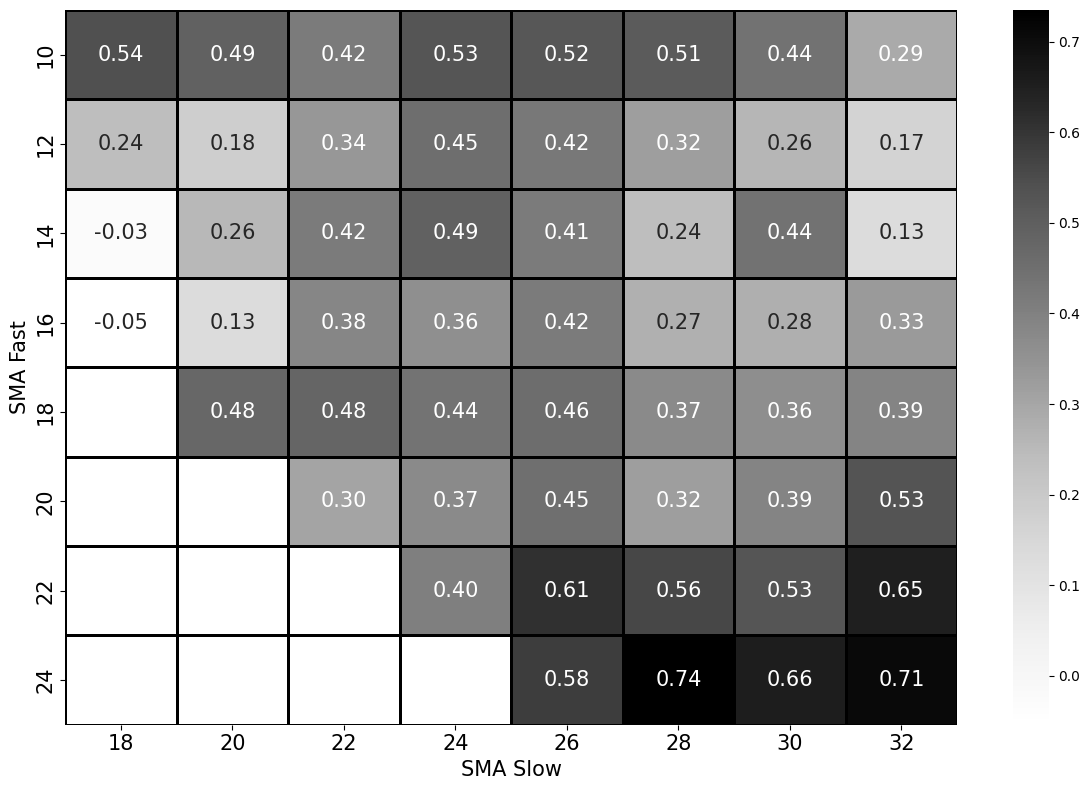

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(results)
# increase the resolution of the plot

# Pivot for heatmap
heatmap_data = df.pivot(index='sma_fast', columns='sma_slow', values='sharpe_ratio')

# Plot grayscale heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='Greys', cbar=True, linewidths=1, linecolor='black', annot_kws={"size": 15})

# heatmap annot font size greater
plt.ylabel('SMA Fast', fontsize=15)
plt.xlabel('SMA Slow', fontsize=15)
# axis values should be larger
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

## Walk Forward optimization

### Run Walk Forward Optimization

In [6]:
from chapter_7 import WalkForwardOptimizer, generate_walkforward_iterations
from datetime import datetime
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

TICKERS = ['SPY', 'VEA', 'EEM', 'GLD', 'BIL']
START_DATE = '2020-01-01'
END_DATE = '2024-12-31'
 
# FETCH DATA
ohlc_list = {}
for ticker in TICKERS:
    df = yf.Ticker(ticker).history(
        start=START_DATE,
        end=END_DATE,
        interval='1d'
    )
    df.index = df.index.tz_localize(None)
    ohlc_list[ticker] = df


warmup_periods = 32
# Define parameter grid for SMA optimization
param_grid = {
    'sma_fast': [12, 14, 16, 18, 20],
    'sma_slow': [24, 26, 28, 30, 32]
}
 
iterations = generate_walkforward_iterations(
    start_date=datetime(2020, 1, 1),
    end_date=datetime(2024, 12, 31),
    in_sample_months=6,
    out_sample_months=6,
)

# Initialize Walk-Forward Optimizer
walkforward = WalkForwardOptimizer(
    strategy=SMAStrategy,
    param_grid=param_grid,
    iterations=iterations,
    data=ohlc_list,
    warmup_periods=warmup_periods,
    objective='sharpe_ratio',
)
 
# Run Walk-Forward Optimization
results = walkforward.run()


100%|██████████| 93/93 [00:00<00:00, 406.52it/s]


{'sma_fast': 20, 'sma_slow': 32}


100%|██████████| 128/128 [00:00<00:00, 365.94it/s]


{'sma_fast': 12, 'sma_slow': 24}


100%|██████████| 124/124 [00:00<00:00, 330.26it/s]


{'sma_fast': 18, 'sma_slow': 32}


100%|██████████| 128/128 [00:00<00:00, 426.62it/s]


{'sma_fast': 12, 'sma_slow': 30}


100%|██████████| 124/124 [00:00<00:00, 374.74it/s]


{'sma_fast': 18, 'sma_slow': 26}


100%|██████████| 127/127 [00:00<00:00, 418.74it/s]


{'sma_fast': 14, 'sma_slow': 24}


100%|██████████| 124/124 [00:00<00:00, 389.58it/s]


{'sma_fast': 20, 'sma_slow': 30}


100%|██████████| 126/126 [00:00<00:00, 400.14it/s]


{'sma_fast': 18, 'sma_slow': 24}


100%|██████████| 124/124 [00:00<00:00, 378.50it/s]


{'sma_fast': 20, 'sma_slow': 32}


100%|██████████| 127/127 [00:00<00:00, 388.46it/s]


### Plot Matrix of Heatmaps

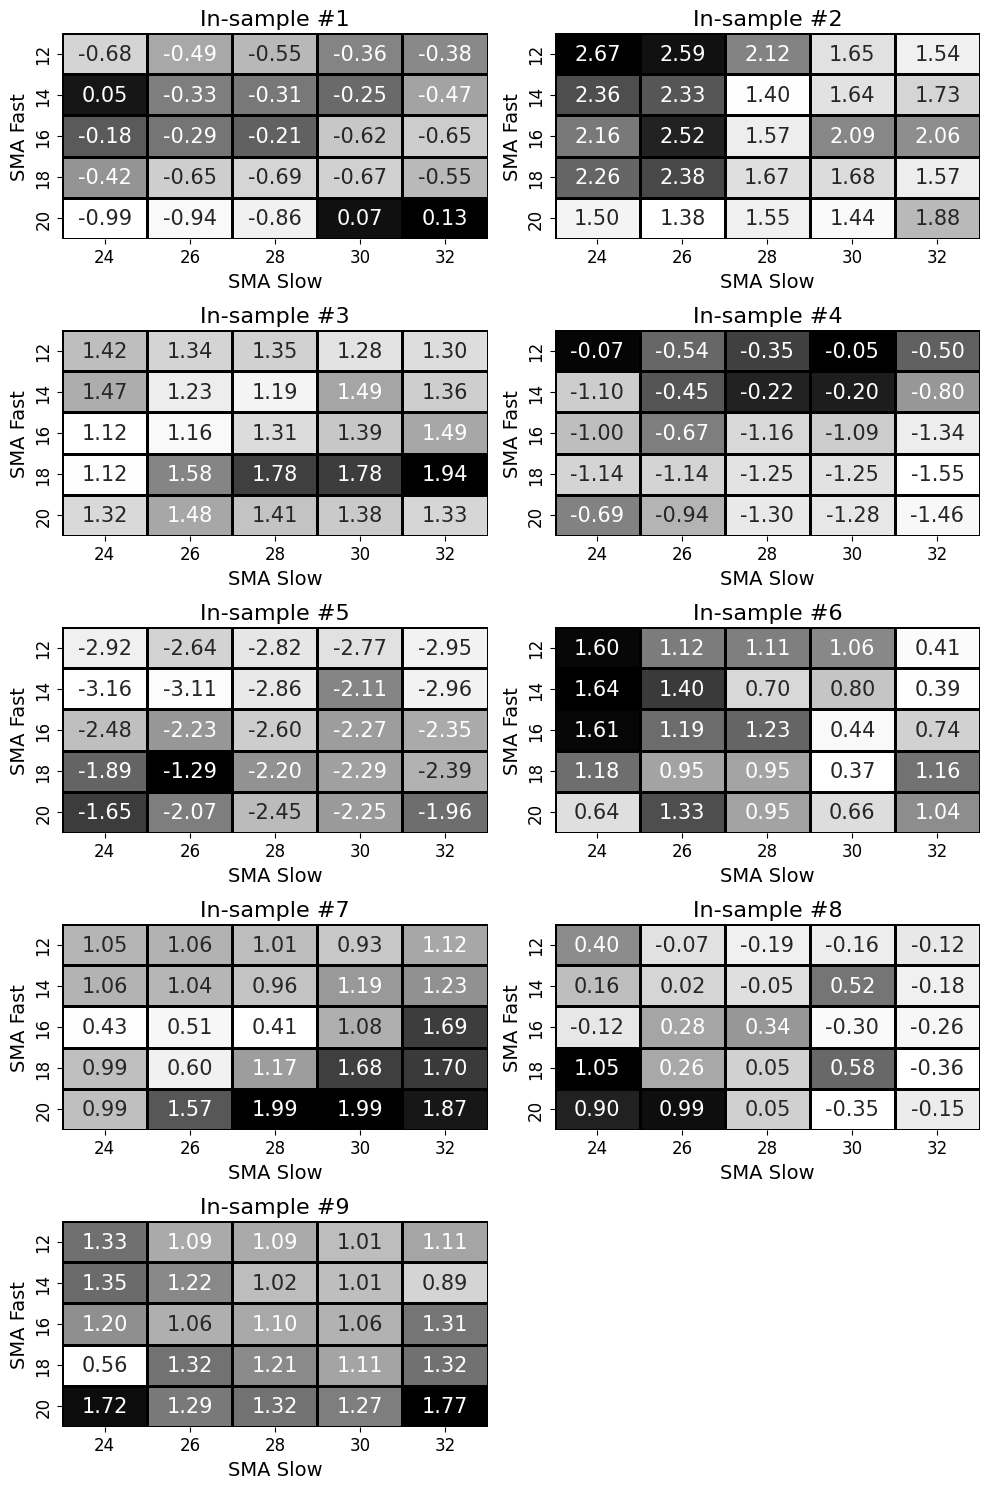

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.style.use('classic')
plt.rcParams.update(plt.rcParamsDefault)

heatmap_data = results['is_iterations']
fig, axes = plt.subplots(5, 2, figsize=(10, 15))
axes_flat = axes.flat

for idx, ax in enumerate(axes_flat):
    if idx >= len(heatmap_data):
        fig.delaxes(ax)  # remove the unused subplot
        continue
    df = pd.DataFrame(heatmap_data[idx])
    pivot = df.pivot(index='sma_fast', columns='sma_slow', values='sharpe_ratio')
    sns.heatmap(
        pivot, annot=True, fmt=".2f", cmap="Greys", ax=ax, cbar=False,
        linewidths=1, linecolor='black', annot_kws={"size": 15}
    )
    ax.set_title(f"In-sample #{idx+1}", fontsize=16)
    ax.set_ylabel("SMA Fast", fontsize=14)
    ax.set_xlabel("SMA Slow", fontsize=14)
    # ticks fontsize
    ax.tick_params(axis='both', which='major', labelsize=12)
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Plot the stitched together time series

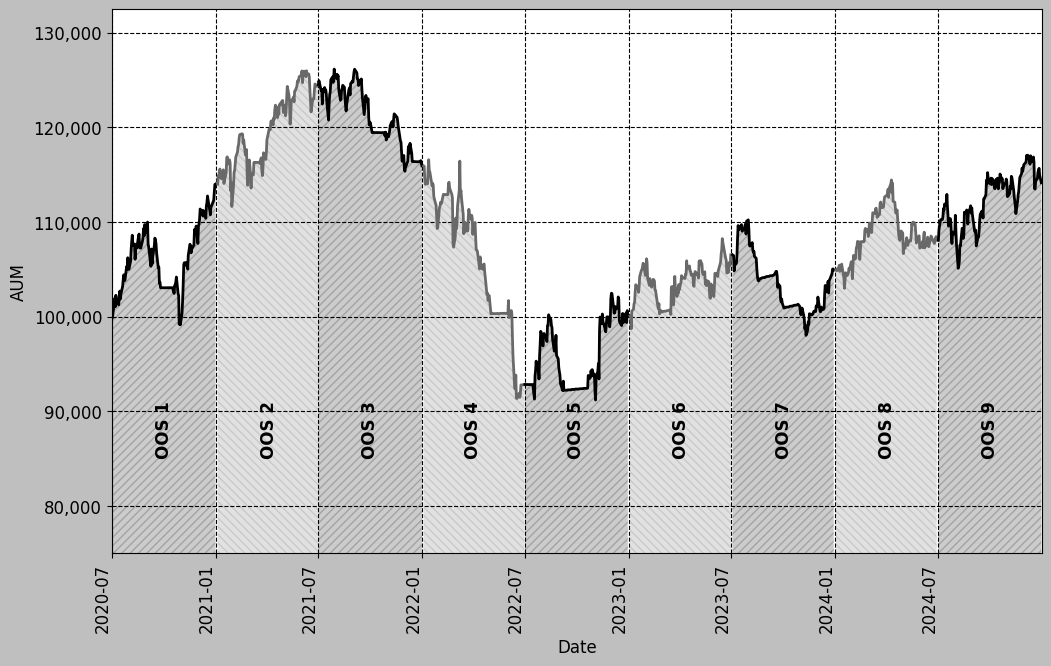

In [ ]:
import pandas

# stitch all aum_series together
aum_series = pd.concat(results['aum_series'].tolist(), axis=1)
# grayscale
plt.style.use('grayscale')
# Rebase each column based on the previous one
rebased = aum_series.copy()

for i in range(1, rebased.shape[1]):
    last_val = rebased.iloc[:, i - 1].dropna().iloc[-1]
    first_val = rebased.iloc[:, i].dropna().iloc[0]
    factor = last_val / first_val
    rebased.iloc[:, i] *= factor

import matplotlib.pyplot as plt

# Define alternating line, fill colors, and hatch patterns
line_colors = ['black', 'dimgrey'] * (rebased.shape[1] // 2 + 1)
fill_colors = ['black', 'dimgrey'] * (rebased.shape[1] // 2 + 1)
hatch_patterns = ['////', '\\\\\\\\'] * (rebased.shape[1] // 2 + 1)

fig, ax = plt.subplots(figsize=(12, 8))

for i, col in enumerate(rebased.columns):
    series = rebased[col].dropna()
    series.plot(ax=ax, color=line_colors[i], linewidth=2)
    ax.fill_between(
        series.index,
        series.values,
        color=fill_colors[i],
        alpha=0.2,
        hatch=hatch_patterns[i],
        edgecolor=fill_colors[i],
        linewidth=0.0
    )
# make it bold
    # Fixed label height at Y = 80000
    mid_date = series.index[len(series) // 2]
    ax.text(
        mid_date,
        85000,
        f'OOS {i+1}',
        fontsize=12,
        color='black',
        ha='center',
        va='bottom',
        rotation=90,
        weight='bold'
    )

# Y-axis formatting
ax.get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
)

# Set min Y-axis value
ax.set_ylim(75000, None)
# x rotate 90
plt.xticks(rotation=90, fontsize=12)
# y fontsize
plt.yticks(fontsize=12)
# x starts in 2020-07
ax.set_xlim(pd.Timestamp('2020-07-01'), pd.Timestamp('2024-12-31'))
# Labels and grid
plt.ylabel("AUM", fontsize=12)
plt.xlabel("Date", fontsize=12)
ax.grid(True, linestyle='--', color='black')
plt.show()

